In [53]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import ipywidgets as widgets
from matplotlib.ticker import FormatStrFormatter
import pytraj as pt
import nglview as nv

# read in the data

df_DNA = pd.read_csv('./uptake_summary_table_DNA.csv', header=0) #change csv name
df_IPTG = pd.read_csv('./uptake_summary_table_IPTG.csv', header=0)

# catalog unique peptides in both states

timepoints = df_DNA['Deut Time (sec)'].unique()
timepoints = list(timepoints)
timepoints.pop()
timepoints.pop()
timepoints = [int(i) for i in timepoints]
peptides_DNA = df_DNA['Sequence'].unique()
peptides_IPTG = df_IPTG['Sequence'].unique()

df_peptides_resnum = df_DNA[["Start","End","Sequence"]]
df_peptides_resnum = df_peptides_resnum.drop_duplicates()
peptide_resnums = {}
for index, row in df_peptides_resnum.iterrows():
    peptide_resnums[ row['Sequence'] ] = row['Start'], row['End']

peptides_both_ = set(peptides_DNA).intersection(peptides_IPTG)
peptides_both = []
for x in peptides_both_:
    if type(x) is str:
        peptides_both.append(x)
peptides_one = set(peptides_DNA).difference(peptides_IPTG)

# remove peptides with limited exchange data in one or both states

peptides_both_complete = []
for peptide in peptides_both:
    print(peptide)
    DNA_exchanged = []
    IPTG_exchanged = []

    df_DNA_subset = df_DNA[["Sequence","Deut Time (sec)","#D"]]
    df_IPTG_subset = df_IPTG[["Sequence","Deut Time (sec)","#D"]]
    df_DNA_peptide = df_DNA_subset[df_DNA_subset["Sequence"] == peptide]
    df_IPTG_peptide = df_IPTG_subset[df_IPTG_subset["Sequence"] == peptide]
    
    for timepoint in timepoints:
        df_DNA_tp = df_DNA_peptide[df_DNA_peptide["Deut Time (sec)"] == timepoint]
        DNA_exchanged.append(df_DNA_tp['#D'])
        df_IPTG_tp = df_IPTG_peptide[df_IPTG_peptide["Deut Time (sec)"] == timepoint]
        IPTG_exchanged.append(df_IPTG_tp['#D'])
    print(timepoints)
    print(DNA_exchanged)
                
    DNA_timepoints = []
    DNA_index = 0
    DNA_exchanged_ = []
    for x in DNA_exchanged:
        if not math.isnan(float(x)):
            DNA_timepoints.append(timepoints[DNA_index])
            DNA_exchanged_.append(float(x))
        DNA_index = DNA_index + 1
        
    IPTG_timepoints = []
    IPTG_index = 0
    IPTG_exchanged_ = []
    for x in IPTG_exchanged:
        if not math.isnan(float(x)):
            IPTG_timepoints.append(timepoints[IPTG_index])
            IPTG_exchanged_.append(float(x))
        IPTG_index = IPTG_index + 1
    
    if len(DNA_exchanged_) > 3 and len(IPTG_exchanged_) > 3:
        peptides_both_complete.append(peptide)

[30, 45, 60, 300, 1500, 3600, 7200, 14400]
VAQQLAGKQSLLIG
[30, 45, 60, 300, 1500, 3600, 7200, 14400]
[Series([], Name: #D, dtype: object), Series([], Name: #D, dtype: object), Series([], Name: #D, dtype: object), Series([], Name: #D, dtype: object), Series([], Name: #D, dtype: object), Series([], Name: #D, dtype: object), Series([], Name: #D, dtype: object), Series([], Name: #D, dtype: object)]


TypeError: cannot convert the series to <class 'float'>

In [2]:
# widgets: choose a peptide from the culled peptide dataset

dropdown_peptides = []
for peptide in peptides_both_complete:
    peptide_start = str(peptide_resnums.get(peptide)[0])
    peptide_end = str(peptide_resnums.get(peptide)[1])
    dropdown_peptides.append(peptide_start + ' - ' + peptide)

dropdown_peptides = sorted(dropdown_peptides, key=lambda x:x[:3])

DDwidget = widgets.Dropdown(
    options = dropdown_peptides,
    value = '72 - ALHAPSQIVAA',
    description = 'Peptide 1:',
    disabled = False,
)

DDwidget2 = widgets.Dropdown(
    options = dropdown_peptides,
    value = '109 - AAVHNL',
    description = 'Peptide 2:',
    disabled = False,
)

display(DDwidget)
display(DDwidget2)

Dropdown(description='Peptide 1:', index=54, options=('1 - GSSAPAANGEVPTFKL', '1 - GSSAPAANGEVPTFKLVL', '1 - G…

Dropdown(description='Peptide 2:', index=11, options=('1 - GSSAPAANGEVPTFKL', '1 - GSSAPAANGEVPTFKLVL', '1 - G…

/Users/anumglasgow/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/anumglasgow/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



PDB ID: 3M1I (Gsp1-GTP). 

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789

Peptide VEVHPLSF, residues 168-166, shown as orange surface and sticks.
Peptide WLARKLAGNPQL, residues 168-166, shown as blue surface and sticks.


NGLWidget()

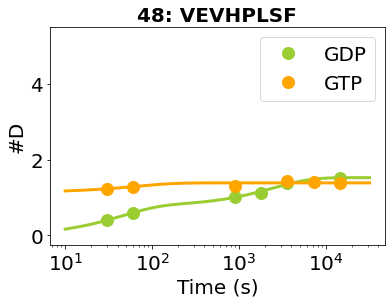

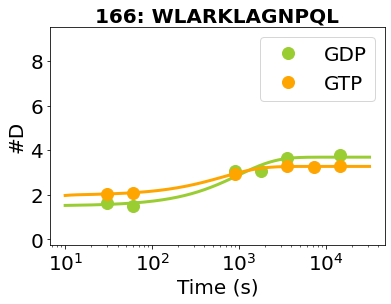

In [5]:
peptide_input1 = str(DDwidget.value)
peptide_input1 = peptide_input1.split()[-1]

peptide_input2 = str(DDwidget2.value)
peptide_input2 = peptide_input2.split()[-1]

selected_peptides = [peptide_input1, peptide_input2]

for peptide in selected_peptides:
    DNA_exchanged = []
    IPTG_exchanged = []
    num_prolines = peptide[2:].count('P')
    max_protons = len(peptide) - 2 - num_prolines

    df_DNA_subset = df_DNA[["Sequence","Deut Time (sec)","#D"]]
    df_IPTG_subset = df_IPTG[["Sequence","Deut Time (sec)","#D"]]
    df_DNA_peptide = df_DNA_subset[df_DNA_subset["Sequence"] == peptide]
    df_IPTG_peptide = df_IPTG_subset[df_IPTG_subset["Sequence"] == peptide]
        
    for timepoint in timepoints:
        df_DNA_tp = df_DNA_peptide[df_DNA_peptide["Deut Time (sec)"] == timepoint]
        DNA_exchanged.append(df_DNA_tp['#D'])
        df_IPTG_tp = df_IPTG_peptide[df_IPTG_peptide["Deut Time (sec)"] == timepoint]
        IPTG_exchanged.append(df_IPTG_tp['#D'])
        
    DNA_timepoints = []
    DNA_index = 0
    DNA_exchanged_ = []
    for x in DNA_exchanged:
        if not math.isnan(float(x)):
            DNA_timepoints.append(timepoints[DNA_index])
            DNA_exchanged_.append(float(x))
        DNA_index = DNA_index + 1
        
    IPTG_timepoints = []
    IPTG_index = 0
    IPTG_exchanged_ = []
    for x in IPTG_exchanged:
        if not math.isnan(float(x)):
            IPTG_timepoints.append(timepoints[IPTG_index])
            IPTG_exchanged_.append(float(x))
        IPTG_index = IPTG_index + 1

    def exchange_fit(x, a, b, c, d, e, f, g):
        max_protons = a + b + c + g - 2 - num_prolines
        d > e
        e > f
        d > f
        return max_protons - a * np.exp(-d * x) - b * np.exp(-e * x) - c * np.exp(-f * x) - g


    DNA_exchanged_list = []
    for element in DNA_exchanged_:
        DNA_exchanged_list.append(float(element))
    IPTG_exchanged_list = []
    for element in IPTG_exchanged_:
        IPTG_exchanged_list.append(float(element))

    trialT = np.logspace(1, 4.5, 10000)
    popt, pcov = curve_fit(f = exchange_fit, xdata = DNA_timepoints, ydata = DNA_exchanged_list,
                           bounds = (0, [max_protons-1, max_protons-1, max_protons-1, 1, 1, 1, max_protons]),
                           maxfev = 100000)
    exchange_DNA = exchange_fit(trialT, *popt)
    perr = np.sqrt(np.diag(pcov))


    trialT = np.logspace(1, 4.5, 10000)
    popt, pcov = curve_fit(f = exchange_fit, xdata = IPTG_timepoints, ydata = IPTG_exchanged_list,
                           bounds = (0, [max_protons-1, max_protons-1, max_protons-1, 1, 1, 1, max_protons]),
                           maxfev = 100000)
    exchange_IPTG = exchange_fit(trialT, *popt)
    perr = np.sqrt(np.diag(pcov))

    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 20
           }
    axes = {'titlesize' : 20,
            'titleweight' : 'bold',
            'labelsize' : 20
           }

    plt.rc('font', **font)
    plt.rc('axes', **axes)
    plt.rc('lines', lw = 3)

    fig, ax = plt.subplots()
    ax.plot(DNA_timepoints, DNA_exchanged_, 'o', color = 'yellowgreen', markersize = 12, label = 'DNA')
    ax.plot(trialT, exchange_DNA, ls = '-', color = 'yellowgreen')
    ax.plot(IPTG_timepoints, IPTG_exchanged_, 'o', markersize = 12, label = 'IPTG', color = 'orange')
    ax.plot(trialT, exchange_IPTG, ls = '-', color = 'orange')
    peptide_start = peptide_resnums.get(peptide)[0]
    peptide_end = peptide_resnums.get(peptide)[0]
    ax.set(xlabel = 'Time (s)', ylabel = '#D', title = str(peptide_start) + ": " + peptide)
    ax.set_ylim(-.25,max_protons+0.5)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    ax.set_xscale('log')
    ax.legend(frameon = True)
    plt.savefig(str(peptide_start) + "_" + peptide + ".png",  transparent=True)

# This section controls the structure widget.


peptide1_start = str(peptide_resnums.get(peptide_input1)[0])
peptide1_end = str(peptide_resnums.get(peptide_input1)[1])
peptide2_start = str(peptide_resnums.get(peptide_input2)[0])
peptide2_end = str(peptide_resnums.get(peptide_input2)[1])

view = nv.NGLWidget()
traj = pt.load('2p9h_REDO.pdb')
view = nv.show_pytraj(traj)
view.add_surface(peptide1_start + "-" + peptide1_end, color = 'orange', opacity='0.5', wireframe=False)
# view.add_ball_and_stick(peptide1_start + "-" + peptide1_end)
view.add_surface(peptide2_start + "-" + peptide2_end, color = 'lightblue', opacity='0.5', wireframe=False)
# view.add_ball_and_stick(peptide2_start + "-" + peptide2_end)
view.add_ball_and_stick('1177-1178')
view.background = "white"

# view.add_representation('line', selection='water') # uncomment this line to see solvent
view._set_size('800px', '600px')

print('''
PDB ID: 2P9H (LacI-IPTG). 

Use the mouse to move the structure. 
Double-click for full-screen. Type "R" to zoom out, "I" to rotate, and "K" to rock.
NGLViewer, an amazing tool: H Nguyen, DA Case and AS Rose, Bioinformatics, 2017. doi:10.1093/bioinformatics/btx789
''')
print('Peptide ' + peptide_input1 + ', residues ' + str(peptide_start+2) + "-" + str(peptide_end) + 
      ', shown as orange surface and sticks.')
print('Peptide ' + peptide_input2 + ', residues ' + str(peptide_start+2) + "-" + str(peptide_end) + 
      ', shown as blue surface and sticks.')
view